# **Rice Leaf Disease Prediction**

Rice is a staple food for a large portion of the world’s population, and diseases affecting rice plants can cause significant yield losses. Early detection of rice leaf diseases is crucial for effective disease management and sustainable crop production.

This project focuses on building and evaluating convolutional neural network (CNN) models to automatically classify rice leaf images into 3 different disease categories :
- **Bacterialblight** – A bacterial infection in rice leaves causing lesions and yellowing.
- **Leafsmut** – A fungal disease that produces black, powdery spores on leaves.
- **Brownspot** – A common rice leaf disease causing brown lesions on the leaf surface.

# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Local
# BASE_DIR = 'Dataset/Train_val'
# BASE_DIR_TEST = 'Dataset'/Test
#collab
BASE_DIR = '/content/drive/MyDrive/Rice leaf/Rice Leaf Diseases Dataset/Train_val/'
BASE_DIR_TEST = '/content/drive/MyDrive/Rice leaf/Rice Leaf Diseases Dataset/Test/'

import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
logging.getLogger('absl').setLevel(logging.ERROR)



# Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import VGG16, MobileNetV2,EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import math
from PIL import Image
import hashlib
from tensorflow.keras.models import load_model


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:

print("🔍 Checking GPU availability...")
print("TensorFlow version:", tf.__version__)
print("GPU devices available:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("✅ GPU IS ACTIVE AND BEING USED!")
    gpu_name = tf.test.gpu_device_name()
    print(f"GPU device name: {gpu_name}")

else:
    print("❌ NO GPU DETECTED - Running on CPU")

🔍 Checking GPU availability...
TensorFlow version: 2.19.0
GPU devices available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU IS ACTIVE AND BEING USED!
GPU device name: /device:GPU:0


# Dataset Link

In [ ]:
DATASET_SOURCE = "Mendeley Data: https://data.mendeley.com/datasets/dwtn3c6w6p/1"
DATASET_LICENSE = "CC BY 4.0"

print(f"Dataset Source: {DATASET_SOURCE}")
print(f"License: {DATASET_LICENSE}")


classes = os.listdir(BASE_DIR)
print("Classes:", classes)


Dataset Source: Mendeley Data: https://data.mendeley.com/datasets/dwtn3c6w6p/1
License: CC BY 4.0
Classes: ['Brownspot', 'Bacterialblight', 'Leafsmut']


# Duplicate Remove

In [ ]:
def remove_duplicate_images(folder_path):
    hashes = {}
    duplicates_removed = 0

    for root, _, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)
            with open(file_path, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()
            if file_hash in hashes:
                os.remove(file_path)
                duplicates_removed += 1
            else:
                hashes[file_hash] = file_path

    print(f"✅ Duplicates removed: {duplicates_removed}")

remove_duplicate_images('/content/drive/MyDrive/Rice leaf/Rice Leaf Diseases Dataset/Train_val/')
remove_duplicate_images('/content/drive/MyDrive/Rice leaf/Rice Leaf Diseases Dataset/Test/')


✅ Duplicates removed: 0
✅ Duplicates removed: 45


# Class Distribution

Brownspot: 997
Bacterialblight: 1157
Leafsmut: 761


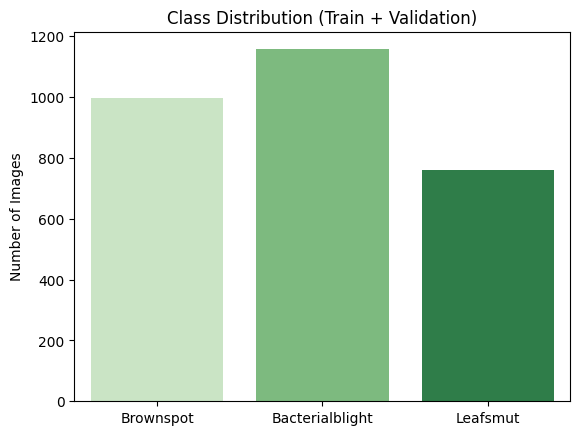

Brownspot: 203
Bacterialblight: 169
Leafsmut: 199


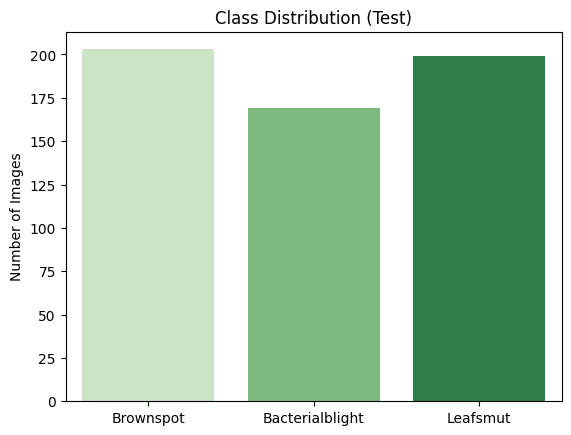

In [ ]:
counts = []
for c in classes:
    num = len(os.listdir(f"{BASE_DIR}/{c}"))
    counts.append(num)
    print(f"{c}: {num}")

sns.barplot(x=classes, y=counts, palette='Greens')
plt.title("Class Distribution (Train + Validation)")
plt.ylabel("Number of Images")
plt.show()

counts = []
for c in classes:
    num = len(os.listdir(f"{BASE_DIR_TEST}/{c}"))
    counts.append(num)
    print(f"{c}: {num}")

sns.barplot(x=classes, y=counts, palette='Greens')
plt.title("Class Distribution (Test)")
plt.ylabel("Number of Images")
plt.show()


The Rice Leaf Disease Dataset consists of images from three disease categories: Bacterial Blight, Leaf Smut, and Brown Spot.
After removing duplicate images, the dataset size was reduced to 3,486 images from an initial total of 4,700 images.
The dataset is organized into training/validation and testing subsets as follows:

**Training and Validation Set:**

Brown Spot: 997 images

Bacterial Blight: 1,157 images

Leaf Smut: 761 images

**Test Set:**

Brown Spot: 203 images

Bacterial Blight: 169 images

Leaf Smut: 199 images

# Sample Images

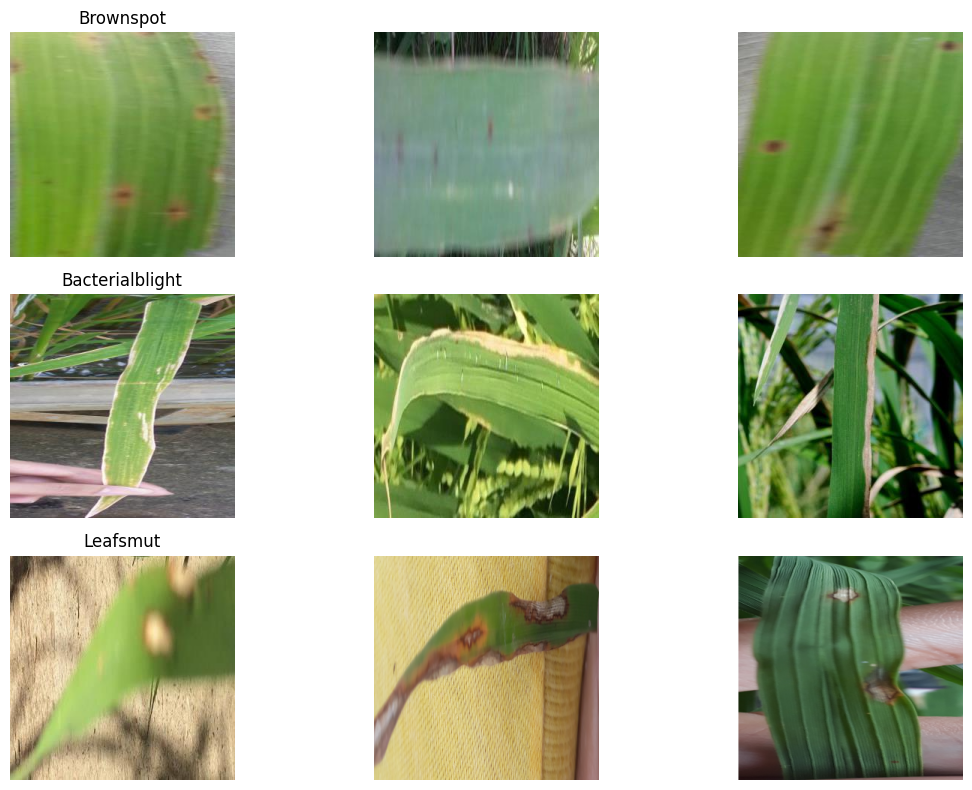

In [ ]:
images_per_class = 3

plt.figure(figsize=(12, 8))

for i, cls in enumerate(classes):
    cls_folder = os.path.join(BASE_DIR, cls)
    img_files = random.sample(os.listdir(cls_folder), images_per_class)

    for j, img_file in enumerate(img_files):
        img_path = os.path.join(cls_folder, img_file)
        img = Image.open(img_path)
        plt.subplot(len(classes), images_per_class, i*images_per_class + j + 1)
        plt.imshow(img)
        plt.title(cls if j==0 else "")
        plt.axis('off')

plt.tight_layout()
plt.show()


# Data Preprocessing

In [ ]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
datagen_trainval = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    validation_split=0.15
)

train_gen = datagen_trainval.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
)

val_gen = datagen_trainval.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    BASE_DIR_TEST,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)



Found 2479 images belonging to 3 classes.
Found 436 images belonging to 3 classes.
Found 571 images belonging to 3 classes.


# Models

## Custom CNN Baseline

Epoch 1/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 62s 708ms/step - accuracy: 0.4446 - loss: 1.9332 - val_accuracy: 0.6560 - val_loss: 0.7751
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 49s 629ms/step - accuracy: 0.6804 - loss: 0.7511 - val_accuracy: 0.7500 - val_loss: 0.6390
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 48s 617ms/step - accuracy: 0.7320 - loss: 0.6789 - val_accuracy: 0.7339 - val_loss: 0.6833
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 49s 634ms/step - accuracy: 0.7487 - loss: 0.6526 - val_accuracy: 0.7523 - val_loss: 0.6381
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 637ms/step - accuracy: 0.7230 - loss: 0.6633 - val_accuracy: 0.7385 - val_loss: 0.5627
Epoch 6/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 52s 666ms/step - accuracy: 0.7488 - loss: 0.6280 - val_accuracy: 0.7752 - val_loss: 0.5383
Epoch 7/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 48s 621ms/step - accuracy: 0.7722 - loss: 0.5846 - val_accuracy: 0.7500 - val_loss: 0.5479
Epoch 8/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 51s 650ms/step - accuracy: 0.7885 - loss: 0.5285 - val_accu

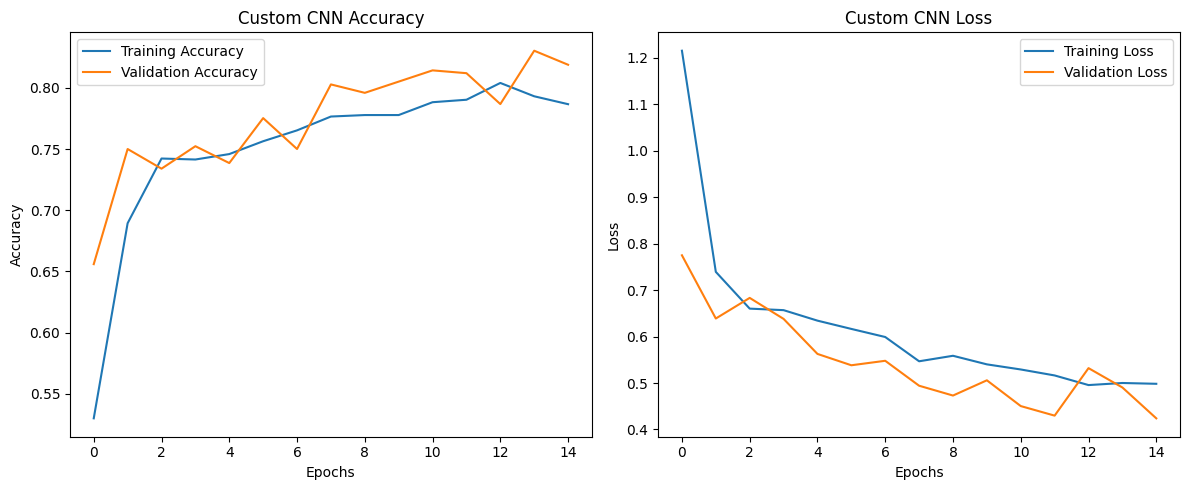

In [ ]:
model_custom = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(48, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model_custom.compile(optimizer=Adam(),
                     loss='categorical_crossentropy', metrics=['accuracy'])

history = model_custom.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    steps_per_epoch=math.ceil(train_gen.samples/BATCH_SIZE),
    validation_steps=math.ceil(val_gen.samples/BATCH_SIZE)
)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Custom CNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Custom CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


## MobileNetV2

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.4592 - loss: 3.0655 - val_accuracy: 0.7408 - val_loss: 2.0786
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 49s 633ms/step - accuracy: 0.7088 - loss: 2.1064 - val_accuracy: 0.8486 - val_loss: 1.7137
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 51s 658ms/step - accuracy: 0.7966 - loss: 1.7444 - val_accuracy: 0.8922 - val_loss: 1.3986
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 648ms/step - accuracy: 0.8439 - loss: 1.4463 - val_accuracy: 0.9014 - val_loss: 1.2036
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 647ms/step - accuracy: 0.8683 - loss: 1.2792 - val_accuracy: 0.9151 - val_loss: 1.0060
Epoch 6/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 639ms/step - accuracy: 0.8700 - loss: 1.0861 - val_accuracy: 0.9404 - val_loss: 0.8439
Epoch 7/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 645ms/step - accuracy: 0.8983 - loss: 0.9484 - val_accuracy: 0.9289 - val_loss: 0.7522
Epoch 8/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 51s 648ms/ste

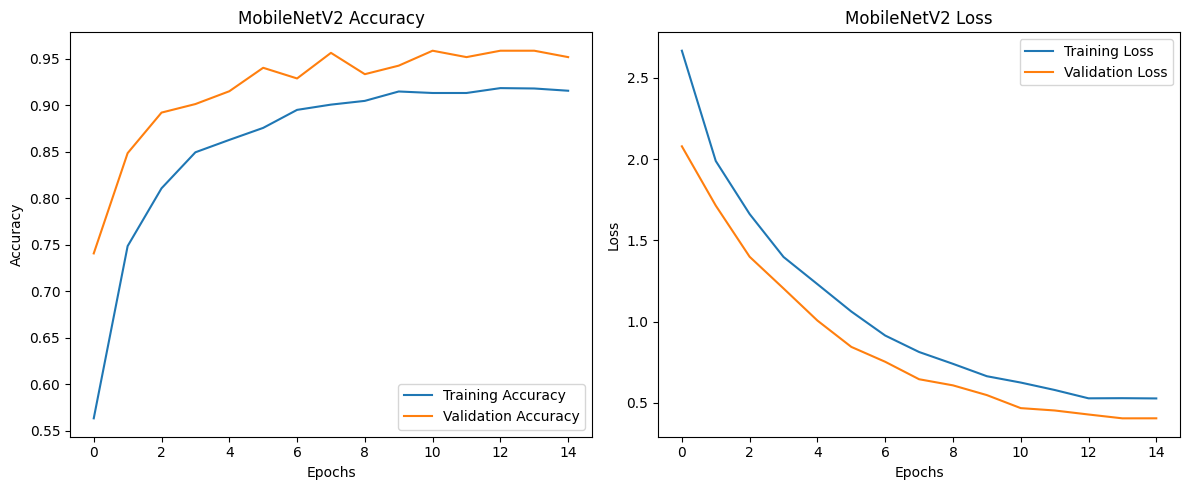

In [ ]:
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))

model_mobilenet = Sequential([
    base_mobilenet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dropout(0.4),
    Dense(len(train_gen.class_indices), activation='softmax')
])

base_mobilenet.trainable = False

model_mobilenet.compile(optimizer=Adam(),
                        loss='categorical_crossentropy', metrics=['accuracy'])

history_mobilenet = model_mobilenet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    steps_per_epoch=math.ceil(train_gen.samples/BATCH_SIZE),
    validation_steps=math.ceil(val_gen.samples/BATCH_SIZE)
)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.title("MobileNetV2 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_mobilenet.history['loss'], label='Training Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.title("MobileNetV2 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


## Efficientnet

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.3735 - loss: 2.9959 - val_accuracy: 0.3968 - val_loss: 2.6967
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 643ms/step - accuracy: 0.3749 - loss: 2.7866 - val_accuracy: 0.3417 - val_loss: 2.6588
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 638ms/step - accuracy: 0.3767 - loss: 2.6935 - val_accuracy: 0.3417 - val_loss: 2.6181
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 51s 655ms/step - accuracy: 0.4001 - loss: 2.6335 - val_accuracy: 0.3486 - val_loss: 2.5756
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 648ms/step - accuracy: 0.3786 - loss: 2.5881 - val_accuracy: 0.3509 - val_loss: 2.5314
Epoch 6/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 648ms/step - accuracy: 0.3709 - loss: 2.5367 - val_accuracy: 0.3555 - val_loss: 2.4870
Epoch 7/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 639ms/step - accuracy: 0.4009 - loss: 2.4875 - val_accuracy: 0.3555 - val_loss: 2.4421
Epoch 8/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 644ms/

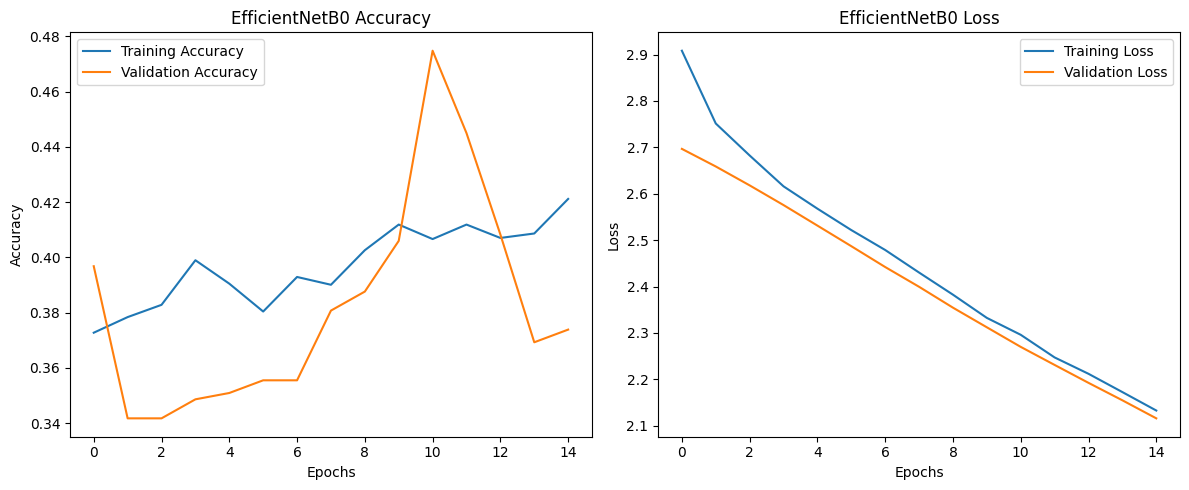

In [ ]:
base_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))


model_efficientnet = Sequential([
    base_efficientnet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dropout(0.4),
    Dense(len(train_gen.class_indices), activation='softmax')
])


base_efficientnet.trainable = False


model_efficientnet.compile(optimizer=Adam(learning_rate=0.0001),
                           loss='categorical_crossentropy', metrics=['accuracy'])


history_efficientnet = model_efficientnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    steps_per_epoch=math.ceil(train_gen.samples / BATCH_SIZE),
    validation_steps=math.ceil(val_gen.samples / BATCH_SIZE)
)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_efficientnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.title("EfficientNetB0 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_efficientnet.history['loss'], label='Training Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.title("EfficientNetB0 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


# Best Model

In [ ]:
model_mobilenet.save('/content/drive/MyDrive/Rice leaf/Best Model/mobilenet_trained.h5')

print("✅ Model saved successfully!")


✅ Model saved successfully!


# Best Model Prediction

18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 429ms/step
Classes: ['Bacterialblight', 'Brownspot', 'Leafsmut']
Classification Report:
                  precision    recall  f1-score   support

Bacterialblight       0.95      0.99      0.97       169
      Brownspot       0.99      0.99      0.99       203
       Leafsmut       0.99      0.95      0.97       199

       accuracy                           0.98       571
      macro avg       0.98      0.98      0.98       571
   weighted avg       0.98      0.98      0.98       571



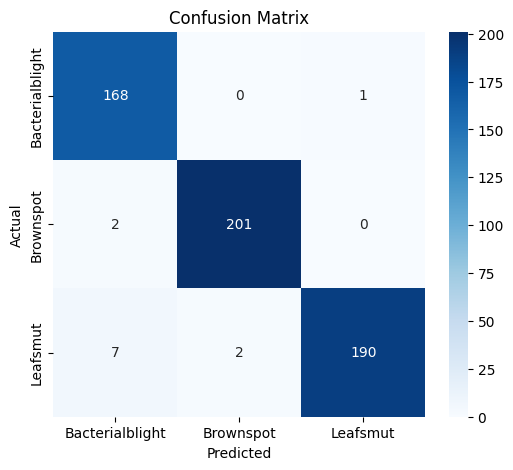

In [ ]:
best_model = load_model('/content/drive/MyDrive/Rice leaf/Best Model/mobilenet_trained.h5')

steps = int(np.ceil(test_gen.samples / BATCH_SIZE))

preds = best_model.predict(test_gen, steps=steps)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

class_names = list(test_gen.class_indices.keys())
print("Classes:", class_names)


report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
